In [28]:
import numpy as np
import os as os
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
import plotly.express as px

#setting up dataset paths
base_path = r"C:\Users\Mehrab\test\Kaggle_projects\titanic"
train_path = os.path.join(base_path, 'train.csv')
test_path = os.path.join(base_path, 'test.csv')

#reading in datasets
train_data = pandas.read_csv(train_path)
test_data = pandas.read_csv(test_path)

In [29]:
#Inspecting data manually for predictive variables
#summarising subsets of data for visual inspection
train_data[(train_data['Pclass'] == 3) & (train_data['Survived'] == 0)].describe()

#Notes: Pclass, Sex, SibSp and Parch are decent predictors of survival as a first pass; 
#Fare and PClass are pretty strongly correlated

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,372.000000,372.0,372.0,270.000000,372.000000,372.000000,372.000000
mean,453.580645,0.0,3.0,26.555556,0.672043,0.384409,13.669364
std,263.090509,0.0,0.0,12.334882,1.504700,0.914144,12.118338
min,1.000000,0.0,3.0,1.000000,0.000000,0.000000,0.000000
25%,206.750000,0.0,3.0,19.000000,0.000000,0.000000,7.750000
50%,470.000000,0.0,3.0,25.000000,0.000000,0.000000,8.050000
75%,679.500000,0.0,3.0,33.000000,1.000000,0.000000,15.136450
max,891.000000,0.0,3.0,74.000000,8.000000,6.000000,69.550000


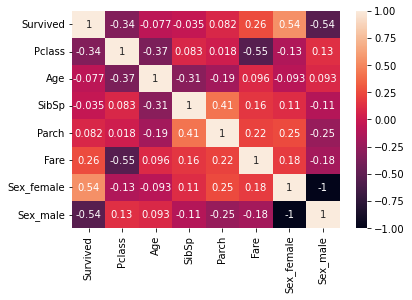

In [30]:
#Manual inspection part2

#only keeping columns that are useful and creating dummies for useful categorical columns
train_data = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
test_data = test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]

#Replacing categoricals with dummy variables
train_data_d = pandas.get_dummies(train_data, dummy_na = False)
test_data_d = pandas.get_dummies(test_data, dummy_na = False)

#plotting correlation matrix
corr_mat = train_data_d.corr()
sns.heatmap(corr_mat, annot=True)
plt.show()

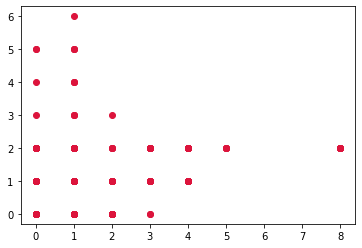

In [31]:
#checking if SibSp and Parch are highly correlated
plt.scatter(train_data_d['SibSp'],train_data_d['Parch'], color = 'crimson')

#They are not. Leaving both in the training set.

In [77]:
#Data cleaning - since we know what columns are desirable, check for missing values in each
nan_locs = pandas.isna(train_data)    #done before dummy variables are created so n-rows don't match with dataframe containing dummy vars
print(nan_locs.shape)
nan_locs.describe()
print(nan_locs.sum())
print('\n')

#checking test data for NaNs
nan_locs_tr = pandas.isna(test_data)    #done before dummy variables are created so n-rows don't match with dataframe containing dummy vars
print(nan_locs_tr.shape)
print(nan_locs_tr.sum())

#~ 25% of age values are missing. 
#Creating three types of datasets: 
#1. All data included, Nans set to 0
#2. Rows containing Nans excluded, Age included (lose 25% of training and test data)
#3. Age excluded

#1. NaNs set to 0 
train_data_nanzer = train_data.fillna(0)   #replacing nans with 0's
train_data_nanzer = pandas.get_dummies(train_data_nanzer, dummy_na = False)  #converting 'Sex' to dummies
test_data_nanzer = test_data.fillna(0)   #replacing nans with 0's
test_data_nanzer = pandas.get_dummies(test_data_nanzer, dummy_na = False)  #converting 'Sex' to dummies


#2. Removed rows containing a NaN
train_data_nonans = train_data.dropna(axis = 0)
train_data_nonans = pandas.get_dummies(train_data_nonans)
test_data_nonans = test_data.dropna(axis = 0)
test_data_nonans = pandas.get_dummies(test_data_nonans)

#3. Dropped the Age column and replaced any other rare, NaNs with 0
train_data_noage = train_data[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]
train_data_noage = pandas.get_dummies(train_data_noage)
test_data_noage = test_data[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]
test_data_noage = pandas.get_dummies(test_data_noage)

train_data_trimmed = train_data[['Survived', 'Sex']]
train_data_trimmed = pandas.get_dummies(train_data_trimmed)

(891, 7)
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64


(418, 6)
Pclass     0
Sex        0
Age       86
SibSp      0
Parch      0
Fare       1
dtype: int64


In [86]:
#Picking which data to train model on
#1. All NaNs set to 0
#train_data_d = train_data_nanzer

#2. All rows containing NaNs are dropped
#train_data_d = train_data_nonans

#3. Age column dropped
#train_data_d = train_data_noage


train_data_d = train_data_nanzer

In [87]:
#creating training, validation and test subsets from the training set
n_rows_train = train_data_d.shape[0] 
n_validation_samps = int(np.floor(n_rows_train/10))

train_data_d_copy = train_data_d

#shuffling training set, then sub-sampling to make training, validation, test splits 
train_data_d_copy = shuffle(train_data_d_copy, random_state = 85)

train_y = train_data_d_copy.iloc[0:(n_rows_train - 2*n_validation_samps), 0]
train_y = train_y.values
train_x = train_data_d_copy.iloc[0:(n_rows_train - 2*n_validation_samps), 1:(train_data_d.shape[1])]
train_x = train_x.values
#dropping rows used to create training set
train_data_d_copy.drop(train_data_d_copy.index[0:(n_rows_train - 2*n_validation_samps)], axis = 0, inplace = True)

valid_y = train_data_d_copy.iloc[0:n_validation_samps, 0]
valid_ = valid_y.values
valid_x = train_data_d_copy.iloc[0:n_validation_samps, 1:(train_data_d.shape[1])]
valid_x = valid_x.values
#dropping rows used to create valid. set
train_data_d_copy.drop(train_data_d_copy.index[0:n_validation_samps], axis = 0, inplace = True)

test_y = train_data_d_copy.iloc[0:n_validation_samps, 0]
test_y = test_y.values
test_x = train_data_d_copy.iloc[0:n_validation_samps, 1:(train_data_d.shape[1])]
test_x = test_x.values



In [88]:
#regularizing train, val and test input data with mean and sd of training data
train_means = np.nanmean(train_x, 0)
train_sds = np.nanstd(train_x, 0)
train_x = (train_x - train_means)/train_sds
valid_x = (valid_x - train_means)/train_sds
test_x = (test_x - train_means)/train_sds

In [89]:
#1. building keras log-reg model
#model = keras.Sequential([
        #layers.Dense(1, activation = 'sigmoid', input_dim = train_x.shape[1])
        #])


#2. building keras dense layer with a single sigmoidal output layer
model = keras.Sequential([
        layers.Dense(12, activation = 'relu', kernel_regularizer= keras.regularizers.l2(0.005), input_dim = train_x.shape[1]),
        layers.Dense(1, activation = 'sigmoid')
        ])


#specifying fit configuration
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])


#running fit with specified parameters
history = model.fit(train_x, train_y, epochs = 30, validation_data = (valid_x, valid_y), verbose = 0)

Text(0, 0.5, 'accuracy')

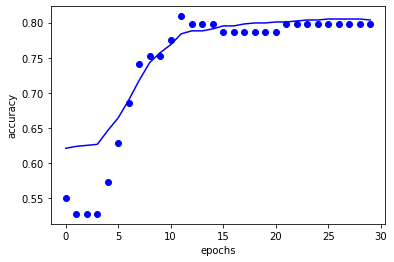

In [90]:
#plotting model performance
fig, (ax1) = plt.subplots()
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'bo')

ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')

In [91]:
#looking at which observations in the validation set the model predicts incorrectly
valid_preds = model.predict(valid_x)
valid_preds = np.round(valid_preds)  #rounding output probabilities to give predictions

3/3 [==============================] - 0s 1ms/step


In [92]:
diffs = np.squeeze(valid_preds) - valid_y
print(diffs[diffs !=0])
print(valid_x[diffs != 0]*train_sds + train_means)

340   -1.0
701   -1.0
510   -1.0
788   -1.0
444   -1.0
838   -1.0
187   -1.0
193   -1.0
755   -1.0
125   -1.0
205    1.0
14     1.0
127   -1.0
220   -1.0
857   -1.0
799    1.0
254    1.0
707   -1.0
Name: Survived, dtype: float64
[[ 2.      2.      1.      1.     26.      0.      1.    ]
 [ 1.     35.      0.      0.     26.2875  0.      1.    ]
 [ 3.     29.      0.      0.      7.75    0.      1.    ]
 [ 3.      1.      1.      2.     20.575   0.      1.    ]
 [ 3.      0.      0.      0.      8.1125  0.      1.    ]
 [ 3.     32.      0.      0.     56.4958  0.      1.    ]
 [ 1.     45.      0.      0.     26.55    0.      1.    ]
 [ 2.      3.      1.      1.     26.      0.      1.    ]
 [ 2.      0.67    1.      1.     14.5     0.      1.    ]
 [ 3.     12.      1.      0.     11.2417  0.      1.    ]
 [ 3.      2.      0.      1.     10.4625  1.      0.    ]
 [ 3.     14.      0.      0.      7.8542  1.      0.    ]
 [ 3.     24.      0.      0.      7.1417  0.      1.    ]
 [ 3

In [ ]:
train_x